## Importowanie bibliotek

In [25]:
import struct
import zlib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

## Funkcje do analizy PNG

In [26]:
def czytaj_png(nazwa_pliku):
    """Czyta plik PNG i zwraca listę chunków"""
    chunki = []
    
    with open(nazwa_pliku, 'rb') as plik:
        # Pomiń sygnaturę PNG (8 bajtów)
        plik.read(8)
        
        # Czytaj chunki
        while True:
            # Długość chunka (4 bajty)
            dlugosc_bajty = plik.read(4)
            if not dlugosc_bajty:
                break
                
            dlugosc = struct.unpack('>I', dlugosc_bajty)[0]
            
            # Typ chunka (4 bajty)
            typ = plik.read(4).decode('ascii')
            
            # Dane chunka
            dane = plik.read(dlugosc)
            
            # CRC (4 bajty)
            crc = struct.unpack('>I', plik.read(4))[0]
            
            chunki.append({
                'typ': typ,
                'dlugosc': dlugosc,
                'dane': dane,
                'crc': crc
            })
            
            if typ == 'IEND':
                break
                
    return chunki

## Wyświetlanie informacji o chunkach

In [27]:
def pokaz_chunki(chunki):
    """Wyświetla informacje o chunkach"""
    print("=== CHUNKI W PLIKU PNG ===\n")
    
    critical = ['IHDR', 'PLTE', 'IDAT', 'IEND']
    
    for chunk in chunki:
        print(f"Typ: {chunk['typ']}")
        print(f"Długość: {chunk['dlugosc']} bajtów")
        
        # Dla IHDR pokaż szczegóły
        if chunk['typ'] == 'IHDR':
            dane = chunk['dane']
            szerokosc = struct.unpack('>I', dane[0:4])[0]
            wysokosc = struct.unpack('>I', dane[4:8])[0]
            glebia_bitowa = dane[8]
            typ_koloru = dane[9]
            
            print(f"  Szerokość: {szerokosc} px")
            print(f"  Wysokość: {wysokosc} px")
            print(f"  Głębia bitowa: {glebia_bitowa}")
            print(f"  Typ koloru: {typ_koloru}")
        
        if chunk['typ'] in critical:
            print("  [CHUNK OBOWIĄZKOWY]")
        else:
            print("  [CHUNK DODATKOWY]")
            
        print("-" * 30)

## Wyświetlanie obrazu

In [28]:
def pokaz_obraz(nazwa_pliku):
    """Wyświetla obraz PNG"""
    obraz = Image.open(nazwa_pliku)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(obraz)
    plt.title("Obraz PNG")
    plt.axis('off')
    plt.show()

## Transformacja Fouriera

In [29]:
def transformacja_fouriera(nazwa_pliku):
    """Wykonuje i wyświetla transformację Fouriera"""
    # Wczytaj obraz jako czarno-biały
    obraz = Image.open(nazwa_pliku).convert('L')
    obraz_tablica = np.array(obraz)
    
    # Wykonaj FFT
    fft = np.fft.fft2(obraz_tablica)
    fft_przesuniete = np.fft.fftshift(fft)
    
    # Widmo amplitudowe
    widmo = np.abs(fft_przesuniete)
    widmo_log = np.log(widmo + 1)
    
    # Wyświetl
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(obraz_tablica, cmap='gray')
    plt.title('Obraz oryginalny')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(widmo_log, cmap='gray')
    plt.title('Widmo Fouriera')
    plt.axis('off')
    
    # Test - odwrotna transformacja
    obraz_odtworzony = np.fft.ifft2(fft)
    obraz_odtworzony = np.real(obraz_odtworzony)
    
    plt.subplot(1, 3, 3)
    plt.imshow(obraz_odtworzony, cmap='gray')
    plt.title('Obraz odtworzony (test)')
    plt.axis('off')
    
    plt.show()
    
    # Sprawdź błąd
    blad = np.mean(np.abs(obraz_tablica - obraz_odtworzony))
    print(f"Błąd rekonstrukcji: {blad:.10f}")
    if blad < 0.0001:
        print("Transformacja działa poprawnie!")

## Anonimizacja

In [30]:
def anonimizuj(nazwa_pliku, nazwa_wyjsciowa):
    """Usuwa dodatkowe chunki z pliku PNG"""
    critical = ['IHDR', 'PLTE', 'IDAT', 'IEND']
    
    with open(nazwa_pliku, 'rb') as wejscie:
        with open(nazwa_wyjsciowa, 'wb') as wyjscie:
            # Skopiuj sygnaturę
            sygnatura = wejscie.read(8)
            wyjscie.write(sygnatura)
            
            # Czytaj i filtruj chunki
            chunki = czytaj_png(nazwa_pliku)
            
            usuniete = 0
            for chunk in chunki:
                if chunk['typ'] in critical:
                    # Zapisz chunk
                    wyjscie.write(struct.pack('>I', chunk['dlugosc']))
                    wyjscie.write(chunk['typ'].encode('ascii'))
                    wyjscie.write(chunk['dane'])
                    wyjscie.write(struct.pack('>I', chunk['crc']))
                else:
                    usuniete += 1
            
    print(f"Usunięto {usuniete} dodatkowych chunków")
    print(f"Plik zapisany jako: {nazwa_wyjsciowa}")

## Główna analiza

=== ANALIZA PLIKU PNG ===

=== CHUNKI W PLIKU PNG ===

Typ: IHDR
Długość: 13 bajtów
  Szerokość: 3000 px
  Wysokość: 4000 px
  Głębia bitowa: 8
  Typ koloru: 2
  [CHUNK OBOWIĄZKOWY]
------------------------------
Typ: pHYs
Długość: 9 bajtów
  [CHUNK DODATKOWY]
------------------------------
Typ: iTXt
Długość: 864 bajtów
  [CHUNK DODATKOWY]
------------------------------
Typ: IDAT
Długość: 8192 bajtów
  [CHUNK OBOWIĄZKOWY]
------------------------------
Typ: IDAT
Długość: 8192 bajtów
  [CHUNK OBOWIĄZKOWY]
------------------------------
Typ: IDAT
Długość: 8192 bajtów
  [CHUNK OBOWIĄZKOWY]
------------------------------
Typ: IDAT
Długość: 8192 bajtów
  [CHUNK OBOWIĄZKOWY]
------------------------------
Typ: IDAT
Długość: 8192 bajtów
  [CHUNK OBOWIĄZKOWY]
------------------------------
Typ: IDAT
Długość: 8192 bajtów
  [CHUNK OBOWIĄZKOWY]
------------------------------
Typ: IDAT
Długość: 8192 bajtów
  [CHUNK OBOWIĄZKOWY]
------------------------------
Typ: IDAT
Długość: 8192 bajtów
  [CHUNK

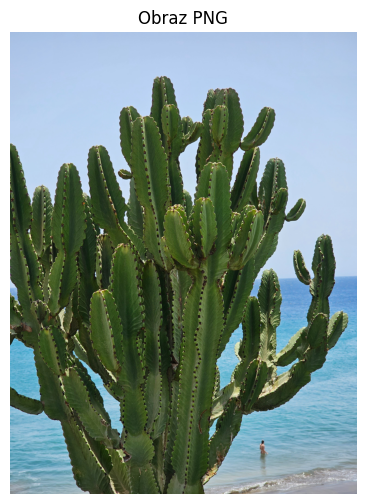


=== TRANSFORMACJA FOURIERA ===


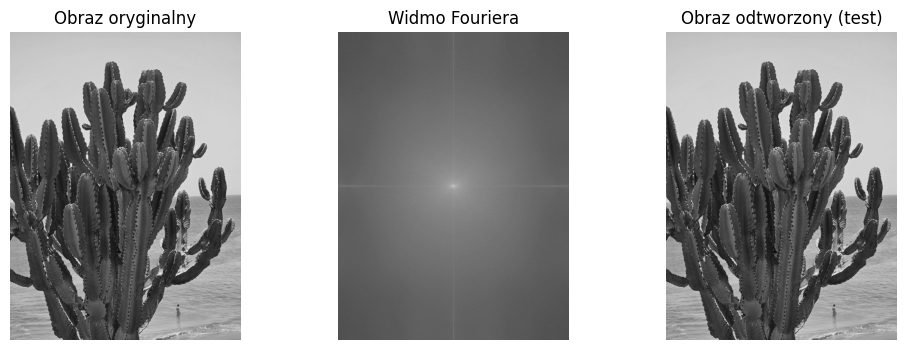

Błąd rekonstrukcji: 0.0000000000
Transformacja działa poprawnie!

=== ANONIMIZACJA ===
Usunięto 2 dodatkowych chunków
Plik zapisany jako: obraz_anonim.png

Rozmiar oryginalny: 21515512 bajtów
Rozmiar po anonimizacji: 21514615 bajtów
Różnica: 897 bajtów


In [31]:
# TUTAJ WPISZ NAZWĘ SWOJEGO PLIKU PNG
nazwa_pliku = 'obraz.png'

print("=== ANALIZA PLIKU PNG ===\n")

# 1. Czytaj chunki
chunki = czytaj_png(nazwa_pliku)

# 2. Pokaż informacje
pokaz_chunki(chunki)

# 3. Wyświetl obraz
print("\n=== OBRAZ ===")
pokaz_obraz(nazwa_pliku)

# 4. Transformacja Fouriera
print("\n=== TRANSFORMACJA FOURIERA ===")
transformacja_fouriera(nazwa_pliku)

# 5. Anonimizacja
print("\n=== ANONIMIZACJA ===")
nazwa_anonimizowana = nazwa_pliku.replace('.png', '_anonim.png')
anonimizuj(nazwa_pliku, nazwa_anonimizowana)

# 6. Porównaj rozmiary
rozmiar_oryginalny = os.path.getsize(nazwa_pliku)
rozmiar_anonimizowany = os.path.getsize(nazwa_anonimizowana)
print(f"\nRozmiar oryginalny: {rozmiar_oryginalny} bajtów")
print(f"Rozmiar po anonimizacji: {rozmiar_anonimizowany} bajtów")
print(f"Różnica: {rozmiar_oryginalny - rozmiar_anonimizowany} bajtów")

## Sprawdzenie efektu anonimizacji

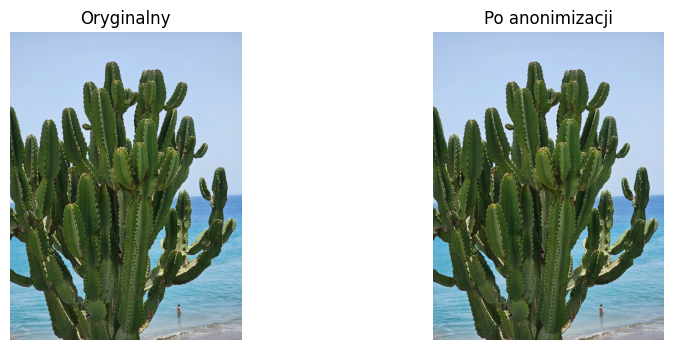

In [32]:
# Porównaj obrazy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(Image.open(nazwa_pliku))
plt.title('Oryginalny')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(Image.open(nazwa_anonimizowana))
plt.title('Po anonimizacji')
plt.axis('off')

plt.show()